<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 70px">

# Client Project: Estimating Neighborhood Affluence with Yelp

<i>
                
                Submitted by Shannon Bingham and Roy Kim
</i>

 
## Problem Statement
The goal of the project is to estimate the affluence of a neighborhood based on the number of `$` of businesses and services (according to Yelp) in a given neighborhood (`$`, `$$`, `$$$`, `$$$$`). The project takes a list of zip codes as input and estimates the wealth of the locality. While traditional methods typically estimate wealth of a locality based on demographic characteristics (e.g. income or unemployment rate), the novelty of this approach is in its use of big data related to commercial activity and cost of product and services as an indicator for affluency.

## Notebook Description
_This notebook will model the data by establishing a baseline score, and use linear regression, Random Forests model, and XGBoost to create models that predict AGI based on the Yelp features that were engineered._

In [1]:
# Importing all necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

%matplotlib inline

In [2]:
# Reading in data
df = pd.read_csv('../data/composite_zip_WI.csv', dtype={'zipcode': 'str'})

In [3]:
# Creating a function that will graph the scatter plot 
# of actual vs predicted points
def plot_model(actual, predictions, title):
    # Set figure.
    plt.figure(figsize=(10,8), facecolor='w')

    # Set up scatterplot.
    plt.scatter(predictions, actual, s=20, c='b', zorder=10)

    # Set labels and title.
    plt.title(title, fontsize=20)
    plt.ylabel('Actual AGI', fontsize = 20)
    plt.xlabel('Predicted AGI', fontsize = 20)
    plt.plot(np.unique(predictions), np.unique(predictions), color = 'red')
    plt.savefig(f'../images/{title}.png', bbox_inches='tight')
    plt.show()

 ## Baseline score
 **Process:** 
- Establish baseline score by using the mean as predicted value for each observation.

**Findings:**
- mean = 63756.1771
- Root Mean Squared Error (RMSE) = 20425.3965
- $R^2$ = 0

In [4]:
# Calculate the mean.
baseline_mean = round(df['average_agi'].mean(),4)
print(baseline_mean)

# Calculate the Root Mean Squared Error (RMSE).
# Use the mean as the predicted value for each observation,
baseline_y_bar = [df['average_agi'].mean() for _ in range(len(df['average_agi']))]

# Calculate the RMSE.
baseline_rmse = round((mean_squared_error(df['average_agi'], baseline_y_bar)**0.5),4)
print(baseline_rmse)

# Calculate R2 (should be 0)
baseline_r2_score = (round(r2_score(df['average_agi'], baseline_y_bar),4))
print(baseline_r2_score)

63756.1771
20425.3965
0.0


We will compare our models' RMSE and $R^2$ scores to the baseline to evaluate effectiveness of the predictions.

## Linear Regression with Select Features
**Process:** 
- Use LinearRegression to model the data.  

**Findings:**
- Root Mean Squared Error (RMSE) = 12793.0686
- R^2 = 0.4273

In [5]:
# Select features to use in the model. 
# These features were selected during the EDA and Feature Engineering process.
features = ['n_d3_grocery',
            'p_ge_d2_gourmet',
            'n_d3_french',
            'n_d3_coffee',
            'n_s3plus_gourmet',
            'n_s2plus_grocery']

# Set features matrix.
X = df[features]

# Set target vector.
y = df['average_agi']

In [6]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state = 42)

In [7]:
# Transform the data to a standard scale.
# Instantiate model.
ss = StandardScaler()

# Transform training and test sets.
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
# Instantiate model.
lr = LinearRegression()

# Fit model.
lr.fit(X_train, y_train)

# Score on training data.
lr.score(X_train, y_train)

0.35513583684040595

In [9]:
# Predict target in test set.
lin_pred = lr.predict(X_test)

# R2 and RMSE
lin_r2 = round(r2_score(y_test, lin_pred),4)
lin_rmse = round(mean_squared_error(y_test, lin_pred) ** 0.5, 4)

print(f'Linear Regression R2: {lin_r2}')
print(f'Linear Regression RMSE: {lin_rmse}')

Linear Regression R2: 0.4274
Linear Regression RMSE: 12793.0686


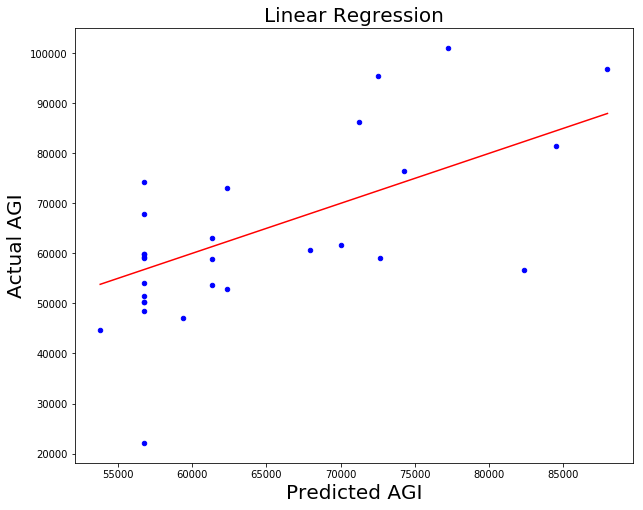

In [10]:
plot_model(y_test, lin_pred, "Linear Regression");

The basic linear regression model with select features produced a much better result than the baseline, with RMSE scores only about \$13,000 off on average for each prediction.

## XGBoost with Select Features
**Process:** 
- Use XGBoost to model the data.  

**Findings:**
- Root Mean Squared Error (RMSE) = 18625.631
- $R^2$ = -0.2138

In [11]:
# XGBoost parameters that will be gridsearched over
xgb_params = {
    'eta' : [0.05, 0.1, 0.3],
    'min_child_weight' : [1, 2, 3],
    'max_depth' : [1, 2, 3, 5],
    'colsample_bytree' : [0.05, .1, .3]
}

# Initializing GridSearch over XGBoost
grid = GridSearchCV(
    XGBRegressor(),
    xgb_params,
    cv = 5,
    verbose = 1,
    return_train_score = True
)

# Fitting the model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    2.4s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'eta': [0.05, 0.1, 0.3], 'min_child_weight': [1, 2, 3], 'max_depth': [1, 2, 3, 5], 'colsample_bytree': [0.05, 0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [12]:
# The best_params_ attribute shows the highest scoring 
# hyperparameters that GridSearch found after fitting
grid.best_params_

{'colsample_bytree': 0.05, 'eta': 0.05, 'max_depth': 2, 'min_child_weight': 1}

In [13]:
# Using the best parameters, I made a list of predictions to compare to the test split
xgboost_pred = grid.predict(X_test)

# R2 and RMSE
xgboost_r2 = round(r2_score(y_test, xgboost_pred),4)
xgboost_rmse = round(mean_squared_error(y_test, xgboost_pred) ** 0.5, 4)

print(f'XGBoost R2: {xgboost_r2}')
print(f'XGBoost RMSE: {xgboost_rmse}')

XGBoost R2: -0.2138
XGBoost RMSE: 18625.631


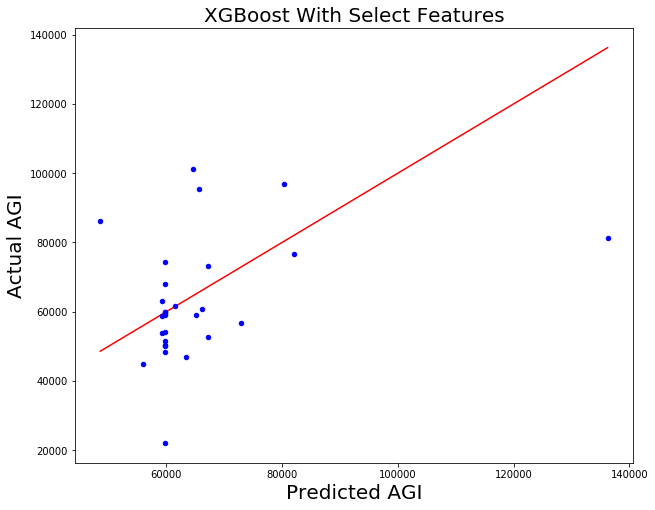

In [14]:
plot_model(y_test, xgboost_pred, 'XGBoost With Select Features')

The XGBoost model did worse than the Linear Regression model, with a negative $R^2$ score, and a larger RMSE. However, it still bested the baseline.

## Random Forest with Select Features
**Process:** 
- Use Random Forest to model the data.  

**Findings:**
- Root Mean Squared Error (RMSE) = 16914.6555
- $R^2$ = -0.0011

In [15]:
# Random Forest parameters to gridsearch over
params = {
    'n_estimators' : [30, 50, 100],
    'max_depth' : [None, 1, 2],
    # Using 1.0 will use all features, quick way to test bagging classifier
    'max_features' : ['auto', 1.0],
    'min_samples_split' : [2,3],
}

# Initializing GridSearch over Random Forest
grid = GridSearchCV(RandomForestRegressor(), 
                    param_grid = params, 
                    cv=5)

# Fitting the model
grid.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [30, 50, 100], 'max_depth': [None, 1, 2], 'max_features': ['auto', 1.0], 'min_samples_split': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
# The best_params_ attribute shows the highest scoring 
# hyperparameters that GridSearch found after fitting
grid.best_params_

{'max_depth': 1,
 'max_features': 1.0,
 'min_samples_split': 3,
 'n_estimators': 50}

In [17]:
# Using the best parameters, I made a list of predictions to compare to the test split
rf_pred = grid.predict(X_test)

# R2 and RMSE
rf_r2 = round(r2_score(y_test, rf_pred),4)
rf_rmse = round(mean_squared_error(y_test, rf_pred) ** 0.5, 4)

print(f'Random Forest R2: {rf_r2}')
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest R2: -0.0906
Random Forest RMSE: 17654.9569


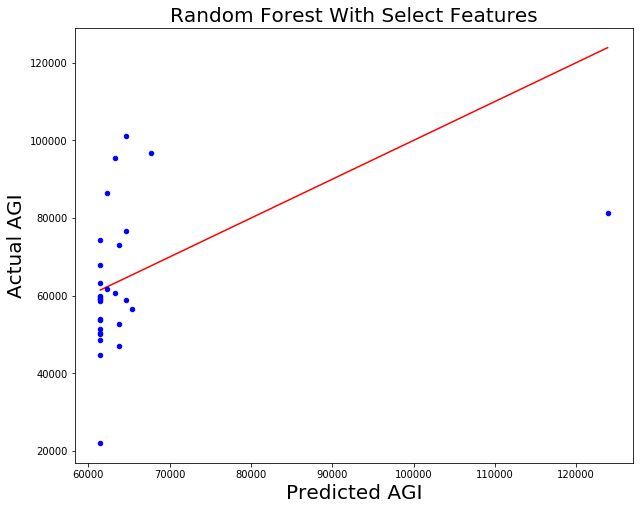

In [18]:
plot_model(y_test, rf_pred, 'Random Forest With Select Features')

The Random Forest Model with select features did well, with a slightly better RMSE than the XGBoost model.

## XGBoost with All Features
**Process:** 
- Use XGBoost to model the data.  

**Findings:**
- Root Mean Squared Error (RMSE) = 20593.7511
- $R^2$ = -0.4839

In [19]:
# Set features matrix with all features except average_agi.
X = df.drop(['average_agi'],axis=1)

# Set target vector.
y = df['average_agi']

In [20]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state = 42)

In [21]:
# Transform the data to a standard scale.
# Instantiate model.
ss = StandardScaler()

# Transform training and test sets.
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [22]:
# XGBoost parameters that will be gridsearched over
xgb_params = {
    'eta' : [0.05, 0.1],
    'min_child_weight' : [1, 2, 3],
    'max_depth' : [5, 7, 9],
    'colsample_bytree' : [.5, .7, .9, 1]
}

# Initializing GridSearch over XGBoost
grid = GridSearchCV(
    XGBRegressor(),
    xgb_params,
    cv = 5,
    verbose = 1,
    return_train_score = True
)

# Fitting the model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.4min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'eta': [0.05, 0.1], 'min_child_weight': [1, 2, 3], 'max_depth': [5, 7, 9], 'colsample_bytree': [0.5, 0.7, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [23]:
# The best_params_ attribute shows the highest scoring 
# hyperparameters that GridSearch found after fitting
grid.best_params_

{'colsample_bytree': 0.7, 'eta': 0.05, 'max_depth': 7, 'min_child_weight': 1}

In [24]:
# Using the best parameters, I made a list of predictions to compare to the test split
xgboost_pred = grid.predict(X_test)

# R2 and RMSE
xgboost_r2 = round(r2_score(y_test, xgboost_pred),4)
xgboost_rmse = round(mean_squared_error(y_test, xgboost_pred) ** 0.5, 4)

print(f'XGBoost R2: {xgboost_r2}')
print(f'XGBoost RMSE: {xgboost_rmse}')

XGBoost R2: -0.4839
XGBoost RMSE: 20593.7511


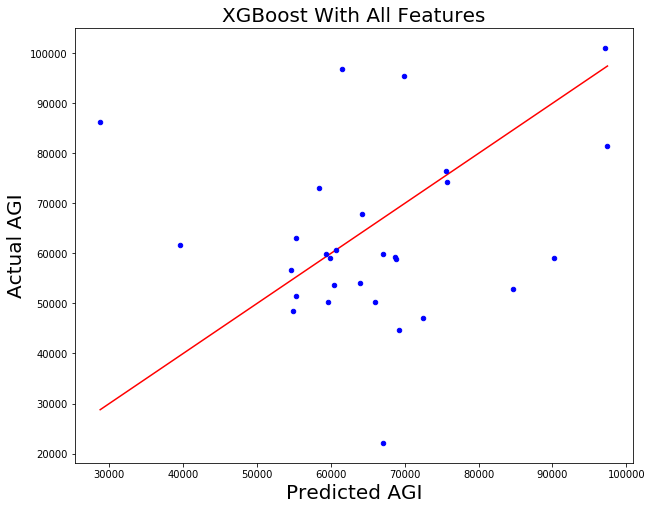

In [25]:
plot_model(y_test, xgboost_pred, 'XGBoost With All Features')

When using XGBoost on all the features, the model scored lower in the RMSE than the baseline.

## Random Forest with All Features
**Process:** 
- Use Random Forest to model the data.  

**Findings:**
- Root Mean Squared Error (RMSE) = 15779.3918
- $R^2$ = 0.1288

In [26]:
# Random Forest parameters to gridsearch over
params = {
    'n_estimators' : [175, 200, 225],
    'max_depth' : [None, 1, 2],
    # Using 1.0 will use all features, quick way to test bagging classifier
    'max_features' : ['auto', 1.0],
    'min_samples_split' : [2,3]
}

# Initializing GridSearch over Random Forest
grid = GridSearchCV(RandomForestRegressor(), 
                    param_grid = params, 
                    cv=5)

# Fitting the model
grid.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [175, 200, 225], 'max_depth': [None, 1, 2], 'max_features': ['auto', 1.0], 'min_samples_split': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
# The best_params_ attribute shows the highest scoring 
# hyperparameters that GridSearch found after fitting
grid.best_params_

{'max_depth': 2,
 'max_features': 1.0,
 'min_samples_split': 3,
 'n_estimators': 200}

In [28]:
# Using the best parameters, I made a list of predictions to compare to the test split
rf_pred = grid.predict(X_test)

# R2 and RMSE
rf_r2 = round(r2_score(y_test, rf_pred),4)
rf_rmse = round(mean_squared_error(y_test, rf_pred) ** 0.5, 4)

print(f'Random Forest R2: {rf_r2}')
print(f'Random Forest RMSE: {rf_rmse}')

Random Forest R2: 0.0924
Random Forest RMSE: 16105.4212


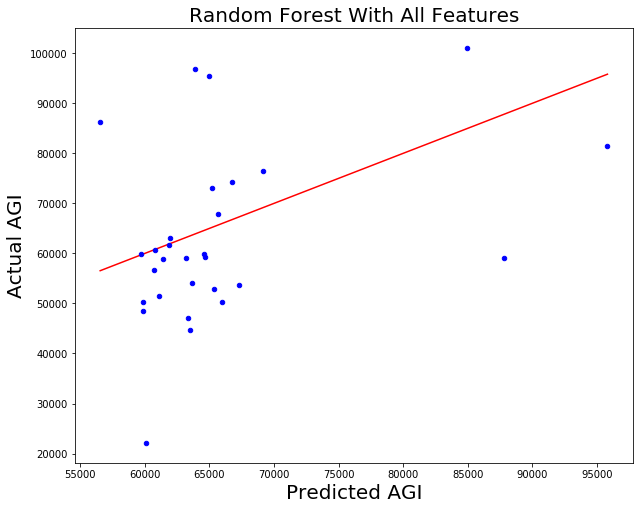

In [29]:
plot_model(y_test, rf_pred, 'Random Forest With All Features')

The Random Forest model with all features performed the second best of all the models, beating the baseline and the other XGBoost and Random Forest models. It seems that the best model is the basic linear regression model with select features, which were selected through the EDA portion.  
It seems that the models that the more advanced models are being strictly penalized by the outliers, whereas the basic linear regression is accounting for the outliers well.